In [13]:
# Imports
import os

import numpy as np
import tensorflow as tf

from skimage import data as skimageData
import matplotlib.image as mpimg
import matplotlib.pyplot as plt 
from skimage import transform

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split

tf.logging.set_verbosity(tf.logging.INFO)

In [41]:
import keras
from keras.layers import Activation, Dropout, Conv2D, MaxPool2D, Dense, Flatten
from keras.models import Sequential
from keras.optimizers import Adam, SGD
from keras.utils import np_utils

from keras.preprocessing.image import array_to_img

In [3]:
# Create a function to load the data
import PIL.Image as im

def is_image(file):
    return file.endswith(".png") or file.endswith(".jpg")

def load_data(data_directory):
    directories = [d for d in os.listdir(data_directory) 
                   if os.path.isdir(os.path.join(data_directory, d))]
    labels = []
    images = []
    
    for d in directories:
        label_directory = os.path.join(data_directory, d)
        file_names = [os.path.join(label_directory, f) 
                      for f in os.listdir(label_directory) 
                      if is_image(f)]
        
        for f in file_names:
            #images.append(skimageData.imread(f))  ##leaving this option for modifications later!
            images.append(im.open(f, 'r').convert("RGB"))
            labels.append(d)
            
    # Rescale the images in the `images` array to 256x256
    images = [transform.resize(np.array(image), (128, 128), mode='constant') for image in images]

    return np.array(images), labels

In [11]:
ROOT_PATH = "./data"
data_directory = os.path.join(ROOT_PATH, "Train")

# load the data into training and testing directories
images, labels = load_data(train_data_directory)

In [12]:
images.shape

(86, 128, 128, 3)

#### Making the train-test split

In [71]:
train_images, test_images, train_labels_original, test_labels_original = train_test_split(images, labels, random_state=42)
encoded = LabelEncoder().fit_transform(train_labels_original)
train_labels = np_utils.to_categorical(encoded)

encoded = LabelEncoder().fit_transform(test_labels_original)
test_labels = np_utils.to_categorical(encoded)

In [72]:
print(train_images.shape)
print(train_labels.shape)

(64, 128, 128, 3)
(64, 2)


In [73]:
print(test_images.shape)
print(test_labels.shape)

(22, 128, 128, 3)
(22, 2)



### Input Layer


In [74]:
def get_model(num_classes):
    model = Sequential()
    
    # Layer 1 (128x128x32)
    model.add(Conv2D(input_shape=(128, 128, 3), kernel_size=(5, 5), filters=32, padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPool2D(pool_size=2, strides=2))
    
    # Layer 2 (64x64x64)
    model.add(Conv2D(kernel_size=(5, 5), filters=64, padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPool2D(pool_size=2, strides=2))
    
    # Layer 3 (32x32x128)
    model.add(Conv2D(kernel_size=(5, 5), filters=128, padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPool2D(pool_size=2, strides=2))
    
    # Layer 4 (16x16x256)
    model.add(Conv2D(kernel_size=(5, 5), filters=256, padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPool2D(pool_size=2, strides=2))
    
    # 65536
    model.add(Flatten())
    
    # Layer 5
    model.add(Dense(4096, activation='relu'))
    
    # Layer 6
    model.add(Dense(4096, activation='relu'))
    
    model.add(Dense(num_classes, activation='softmax'))
    
    adam = Adam(lr=0.0001)
    
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    
    return model

In [75]:
model = get_model(2)

In [76]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 128, 128, 32)      2432      
_________________________________________________________________
activation_17 (Activation)   (None, 128, 128, 32)      0         
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 64, 64, 64)        51264     
_________________________________________________________________
activation_18 (Activation)   (None, 64, 64, 64)        0         
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 32, 32, 128)       204928    
__________

In [ ]:
model.fit(train_images, train_labels, epochs=20, batch_size=32)

Epoch 1/20
64/64 [==============================] - 13s 202ms/step - loss: 0.7779 - acc: 0.5938
Epoch 2/20
64/64 [==============================] - 10s 149ms/step - loss: 0.6820 - acc: 0.4688
Epoch 3/20
64/64 [==============================] - 9s 148ms/step - loss: 0.6046 - acc: 0.7812
Epoch 4/20
64/64 [==============================] - 9s 137ms/step - loss: 0.5467 - acc: 0.8281
Epoch 5/20
64/64 [==============================] - 9s 142ms/step - loss: 0.4397 - acc: 0.8750
Epoch 6/20
64/64 [==============================] - 9s 139ms/step - loss: 0.3139 - acc: 0.8594
Epoch 7/20
64/64 [==============================] - 10s 152ms/step - loss: 0.3809 - acc: 0.8438
Epoch 8/20
64/64 [==============================] - 9s 138ms/step - loss: 0.2998 - acc: 0.9062
Epoch 9/20
64/64 [==============================] - 9s 138ms/step - loss: 0.3162 - acc: 0.8750
Epoch 10/20
64/64 [==============================] - 9s 140ms/step - loss: 0.3292 - acc: 0.7812
Epoch 11/20
64/64 [===========================

In [ ]:
model.evaluate(test_images, test_labels)

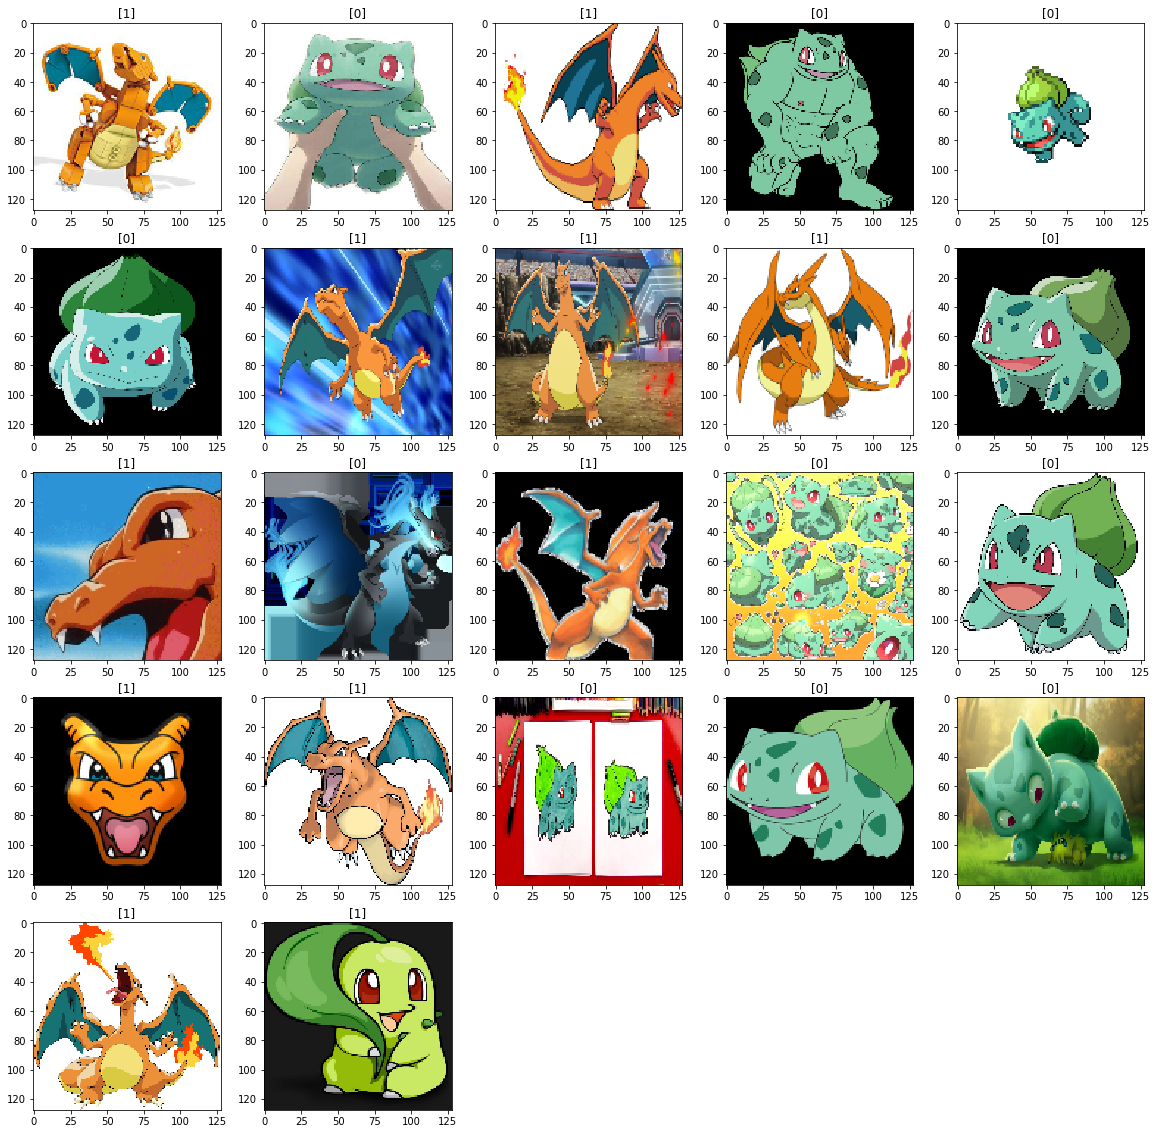

In [67]:
i = 1
k = 0
plt.figure(figsize=(20, 20))
for im in test_images:
    predicted = model.predict_classes(im.reshape(1, 128, 128, 3))[0]
    expected = encoded[k]
    k += 1
    if predicted != expected:
        plt.subplot(5, 5, i)
        plt.imshow(array_to_img(im))
        plt.title()
        i += 1

In [46]:
len(test_images)

22

In [63]:
model.predict_classes(np.array(test_images[0]))

ValueError: Error when checking : expected conv2d_13_input to have 4 dimensions, but got array with shape (128, 128, 3)

In [69]:
model.predict_classes(test_images[0].reshape(1, 128, 128, 3))[0]

1

In [70]:
test_labels

array([[ 0.,  1.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 1.,  0.]])